# Ham vs. Spam


The goal of this project is to take email text and predict whether the email is a spam message or not. A non spam message is called "ham." Here, a logistic regression is used to make a classifier after transforming the email text into numeric features. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [2]:
!pip install utils

In [3]:
original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


# Data Cleaning and Prep

Checking for NaN values and replacing. 

In [4]:
original_training_data.isnull().values.any()
original_training_data.fillna("")

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0
...,...,...,...,...
8343,8343,Subject: Re: ALSA (almost) made easy\n,"thanks for this, i'm going to give them anothe...",0
8344,8344,Subject: Re: Goodbye Global Warming\n,thanks for the link - i'm fascinated by archae...,0
8345,8345,Subject: hello\n,we need help. we are a 14 year old fortune 50...,1
8346,8346,Subject: Your application is below. Expires Ju...,<html>\n \n \n <head> \n <meta charset=3dutf-8...,1


In [5]:
ham = original_training_data.loc[original_training_data["spam"] == 0, ["email"]] #ham
spam= original_training_data.loc[original_training_data["spam"] == 1, ["email"]] #spam

fham = ham.iloc[0]
fspam = spam.iloc[0]


first_ham = fham["email"]
first_spam = fspam["email"]

In [6]:
first_ham

'url: http://boingboing.net/#85534171\n date: not supplied\n \n arts and letters daily, a wonderful and dense blog, has folded up its tent due \n to the bankruptcy of its parent company. a&l daily will be auctioned off by the \n receivers. link[1] discuss[2] (_thanks, misha!_)\n \n [1] http://www.aldaily.com/\n [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf\n \n \n'

In [7]:
first_spam

'<html>\n <head>\n </head>\n <body>\n <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>\n  better equipped than a man with a 5-6"hammer. <br>\n <br>would you rather have<br>more than enough to get the job done or fall =\n short. it\'s totally up<br>to you. our methods are guaranteed to increase y=\n our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=\n 004">come in here and see how</a>\n </body>\n </html>\n \n \n \n'

# Test Train Split

In [8]:
from sklearn.model_selection import train_test_split

[train, val] = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

In [9]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    
    for text in texts:
        current_iteration = []
        for word in words:
            if word in text:
                current_iteration += [1]
            else:
                current_iteration += [0]
        indicator_array += [current_iteration]
        
    return np.array(indicator_array)

In [10]:
words = ["one", "two", "three", "four", "five", "seven"]
texts = train["email"]
inemails = pd.DataFrame(words_in_texts(words, texts), columns = words)
inemails["spam"] = train["spam"]

In [11]:
inemails.head()


,one,two,three,four,five,seven,spam
0,0,0,0,0,0,0,0.0
1,1,1,0,0,0,0,0.0
2,1,0,0,0,0,0,1.0
3,1,1,0,0,0,0,0.0
4,1,1,0,0,0,0,0.0


In [12]:
melted = inemails.melt("spam")
melted.head()

,spam,variable,value
0,0.0,one,0
1,0.0,one,1
2,1.0,one,1
3,0.0,one,1
4,0.0,one,1


In [13]:
y = melted.groupby(["variable","spam"]).mean().reset_index()
y.head()

,variable,spam,value
0,five,0.0,0.032546
1,five,1.0,0.033024
2,four,0.0,0.041476
3,four,1.0,0.041715
4,one,0.0,0.589006


In [14]:
j = y.replace({0:"ham" 
           ,1:"spam"
          })

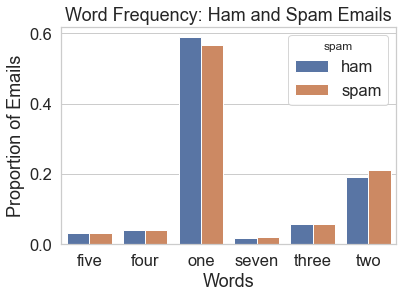

In [15]:
plot = sns.barplot(data = j, x = 'variable', y = 'value', hue = 'spam')

plot.set(xlabel = 'Words', 
         ylabel = 'Proportion of Emails', 
         title = 'Word Frequency: Ham and Spam Emails')

plt.show()

c:\users\ted kumagai\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Distribution')

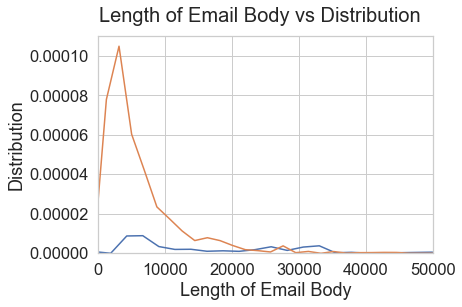

In [16]:
train["length"] = train["email"].str.len()

spliced=train.iloc[:,5:]  #Both the spam and ham values, need to differentiate btw 0 and 1 to sep. data.

hamlen = train[train["spam"] == 0]
spamlen = train[train["spam"] == 1]

plt.xlim(right=50000)
sns.distplot(hamlen["length"], hist=False)
sns.distplot(spamlen["length"], hist=False)

plt.suptitle('Length of Email Body vs Distribution', fontsize=20)
plt.xlabel('Length of Email Body')
plt.ylabel('Distribution')

# Basic Classification

Since the output of words_in_texts(words, train['email']) is a numeric matrix containing features for each email, a classifier can be trained off this data. 

In [17]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

Phi_train = words_in_texts(some_words, train["email"])
Y_train = train["spam"]

Phi_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 7657    0
 6911    0
 6074    0
 4376    0
 5766    0
 Name: spam, dtype: int64)

# Logistic Regression Model

With the previous matricies, a logistic regression model using Phi_train and Y_train. Seen Below, the model is around 76 percent accurate. 

In [18]:
import sklearn.linear_model

model=sklearn.linear_model.LogisticRegression(fit_intercept=True)
model.fit(Phi_train, Y_train)

training_accuracy = np.sum(Y_train == model.predict(Phi_train))/len(Y_train)

training_accuracy

0.7576201251164648

# Precision, Recall, False-Alarms

Presumably, the classifier is should be used for email filtering, preventing spam from reaching an inbox.

To get an idea of how accurate the filter is, several accuracy measurements can be created by creating two catagories of errors:

- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.


With these defintions, overall accuracy can be measured using:


- **Precision** measures the proportion $\frac{TP}{TP + FP}$ of emails correctly flagged as spam.

- **Recall** measures the proportion  $\frac{TP}{TP + FN}$  of spam emails that were correctly flagged as spam

- **False-Alarm Rate** measure the proportion  $\frac{FP}{FP + TN}$  of ham emails that were incorrectly flagged as spam.

In [19]:
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train==1)
zero_predictor_fn

1918

In [20]:
zero_predictor_acc = np.mean(Y_train==0)
zero_predictor_recall = 0
zero_predictor_acc

0.7447091707706642

In [21]:
logistic_predictor_precision = sum((model.predict(Phi_train) == 1) & (Y_train == 1))/ sum(model.predict(Phi_train) == 1)
logistic_predictor_recall = sum((model.predict(Phi_train) == 1) & (Y_train == 1))/ sum(Y_train == 1)


logistic_predictor_far = (
                           sum((model.predict(Phi_train) == 1)&(Y_train == 0))
                          /
                          (
                           sum((model.predict(Phi_train) == 1)&(Y_train == 0))
                           +
                           sum((model.predict(Phi_train) == 0)&(Y_train == 0)))
                         )

In [22]:
logistic_predictor_precision


0.6422287390029325

In [23]:
logistic_predictor_recall


0.11418143899895725

In [24]:
logistic_predictor_far

0.021805183199285077

In [25]:
sum((model.predict(Phi_train) == 1)&(Y_train == 0)) # Fp
sum((model.predict(Phi_train) == 0)&(Y_train == 0)) # Fn

5473

a) Number of False Postive = 0 because the classifier predicts 0 ham for every email. Number of False Negatives = 1918 = sum(Y_train==1)

b) Zero Predictor accuracy = 0.74470917077066423 or 74 % Recall = 0 because agin the classifier predicts 0 ham for every email.

c) Precision = 0.64 or 64% Recall = 0.11 or 11% False Alarm Rate = 0.22 or 22% More False negatives than Flase Positives: 5473 > 122

d) 75.6% > 74% so the logistic classifier is more accurate compared to the zero predictor.

e) Maybe because outliers in the dataset. Certain values may slightly skew the data off. Too few features, overfitting/underfitting etc.

f) The Logistic classifier because the zero predictor just labels everything as SPAM which is not true. At least the Logistic classifier will make SPAM and HAM predictions.

# Kaggle

In a Kaggle email classification competition, my personal goal for this project was to reach 88 percent accuracy, and within the top 200 or so spots on the leaderboard.

1. I created a list of the most frequent words found in a subset of emails and filtered through it to find the most 50 or so most frequently used words. I used common sense in selecting individual words by manually parsing through spam messages and finding buzzphrases. Mainly, I first created a dataframe that stacked individual strings. I then created two functions that gave me the frequency of the string's appearance in spam and ham. After, I used those two definitions to filter the words, finding words that appeared more in spam compared to ham. I then created a tidy format dataframe that stored the words and their frequencies in spam and ham.

2. I tried finding the words manually which was taking forever and was very inefficient. I found a few good words this way, but I got lazy and used a ratio comparison method to have the computer do work for me.

3. Some words that I thought initially were good SPAM words tured out to be actually good HAM words. I also realized that words that most frequently appeared in spam did not neccesarly differentiate spam vs. ham. Common usage words like "the" and "at" turned to be poor features to train on as they appeared in both SPAM and HAM commonly.

In [26]:
spam_mails = train[train['spam']==1]['email']
subset_mails = spam_mails.iloc[0:1] #creating a subset of the data. Adjust iloc int elements to widen sample size

df = subset_mails.to_frame()

j = (
    df['email']
     .str.split(expand=True)
     .stack()
     .reset_index()
     .iloc[:,1:3]
     .set_index('level_1')
)

j.columns = ['word']
del j.index.name

wordlist = (j
     .groupby('word')['word']
     .count()
     .sort_values(ascending=False)
     .iloc[0:1] #number of words to filter out from initial list. Adjust iloc int to widen sampling.
     .to_frame()
     .index.values
    )

def word_percentage_spam(word):
    spam_mails = train[train['spam']==1]['email']
    iteration = []
    for i in spam_mails:
        if str(word) in i:
            iteration.append(1)
        else:
            iteration.append(0)
    return sum(iteration)/len(spam_mails)

def word_percentage_ham(word):
    ham_mails = train[train['spam']==0]['email']
    iteration = []
    for i in ham_mails:
        if str(word) in i:
            iteration.append(1)
        else:
            iteration.append(0)
    return sum(iteration)/len(ham_mails)

In [27]:
frequent_words = []

for element in wordlist:
    if 100*(word_percentage_spam(element) - word_percentage_ham(element))> 30:
        frequent_words.append(element)
    else:
        continue
        
frequent_words

[]

In [28]:
train[train['spam']==1]['email'].iloc[42]


'<html><head><title>free motorola cell phone with $50 cash back!</title>\n <style></style>\n </head>\n <body bgcolor=#ffffff>\n <table align="center" border=0 cellpadding=0 cellspacing=0 width=450>\n   <tbody>\n   <tr>\n     <td><img height=1 src="images/spacer.gif" width=185></td>\n     <td><img height=1 src="images/spacer.gif" width=65></td>\n     <td><img height=1 src="images/spacer.gif" width=50></td>\n     <td><img height=1 src="images/spacer.gif" width=150></td></tr>\n   <tr>\n     <td colspan=2 rowspan=2><a href="http://theadmanager.com/server/c.asp?ad_key=qbfuiexorxkl&ext=1"><img border=0\n       height=150\n       src="http://168.143.181.42/htmlemails/images/t193no_option_01.gif"\n       width=250></a></td>\n     <td rowspan=2><a href="http://theadmanager.com/server/c.asp?ad_key=qbfuiexorxkl&ext=1"><img border=0\n       height=150\n       src="http://168.143.181.42/htmlemails/images/t193no_option_02.gif"\n       width=50></a></td>\n     <td><a href="http://theadmanager.com/ser

In [29]:
some_words_spam = list(set(['you',
 '=',
 '<td',
 'your',
 '</tr>',
 '<tr>',
 '<font',
 '<br>',
 'will',
 'from',
 'our',
 'we',
 '<p',
 '</td>',
 '<table',
 'if',
 'email',
 'sans-serif"',
 '<a',
 'arial,',
 '</table>',
 'free',
 'cialis',
 'congratulations',
 'free',
 'mortgage',
 'opportunity',
 'today!',
 'shipping!',
 'available',
 'prompt',
 'website',
 'fast',
 'here!',
 'prices',
 'here!',
 'fast',
 'true',
 'visit',
 'account',
 'windows',
 'please',
 'want',
 'back',
 'nbsp',
 'mastercard',
 'visa',
 '<html>',
 'unsubscribe',
 'click',
 'your',
 'offer',
 'member',
 'quote',
 'you',
 '=',
 '<td',
 'your',
 '</tr>',
 '<tr>',
 '<font',
 '<br>',
 'our',
 '<p',
 '</td>',
 '<table',
 'email',
 '<a',
 '</table>',
 'please',
 'receive',
 'click',
 '&',
 'order',
 '#',
 'removed',
 'name',
 '<html>',
 '</html>',
 '</body>',
 '</head>',
 '<body',
 'offer',
 '</font>',
 'form',
 '<head>',
 '5',
 'remove',
 '<p>',
 '</p>',
 '<tr',
 'html',
 '&nbsp;',
 'low',
 '<br',
 'text/html;',
 ';']
))

In [30]:
for words in some_words_spam:
    print(str(words) + ':' + "difference = " + str(100*(word_percentage_spam(words)- word_percentage_ham(words))))

<tr>:difference = 29.92173296394349
true:difference = 3.9095870829105013
prices:difference = 5.760701728882391
offer:difference = 25.21915981515598
today!:difference = 5.8932217336162465
you:difference = 26.259648259609126
<p:difference = 34.45631946444064
name:difference = 26.894702461325426
remove:difference = 47.25254654414554
please:difference = 42.65156492138351
back:difference = 5.800631988377828
low:difference = 33.23605632542835
<br:difference = 41.23569476321868
<font:difference = 41.69150543135397
visit:difference = 14.39666169984559
visa:difference = 2.7886696840337675
email:difference = 32.78941517312586
available:difference = 8.818306602890075
<table:difference = 30.47737394012418
free:difference = 21.444618081278815
order:difference = 38.06058217106924
</p>:difference = 30.666476566948187
click:difference = 36.400797300583996
our:difference = 32.31733420555557
if:difference = 23.557101202939833
removed:difference = 28.31861458307125
unsubscribe:difference = 9.794384789786

In [31]:
val_Phi_train = words_in_texts(some_words_spam, val["email"])
Y_train = np.array(val["spam"])

val_Phi_train[:5], Y_train[:5]

model=sklearn.linear_model.LogisticRegression(fit_intercept=True)
model.fit(val_Phi_train, Y_train)

val_accuracy = np.sum(Y_train == model.predict(val_Phi_train))/len(Y_train)


val_accuracy


0.9149700598802395

In [32]:
for words in some_words_spam:
    print("'" 
          + str(words) 
          +"'" 
          + ': ' 
          +'[' 
          + str(round((word_percentage_spam(words)),2)) 
          + "," 
          + str(round((word_percentage_ham(words)),2)) 
          +","
          + str(round(word_percentage_spam(words)
                      -word_percentage_ham(words),2))
          +']' 
          +',')

'<tr>': [0.35,0.05,0.3],
'true': [0.09,0.05,0.04],
'prices': [0.07,0.02,0.06],
'offer': [0.31,0.06,0.25],
'today!': [0.07,0.01,0.06],
'you': [0.87,0.61,0.26],
'<p': [0.4,0.05,0.34],
'name': [0.41,0.14,0.27],
'remove': [0.54,0.06,0.47],
'please': [0.53,0.1,0.43],
'back': [0.25,0.2,0.06],
'low': [0.57,0.24,0.33],
'<br': [0.46,0.05,0.41],
'<font': [0.47,0.05,0.42],
'visit': [0.19,0.05,0.14],
'visa': [0.03,0.0,0.03],
'email': [0.58,0.25,0.33],
'available': [0.16,0.07,0.09],
'<table': [0.35,0.05,0.3],
'free': [0.49,0.28,0.21],
'order': [0.49,0.11,0.38],
'</p>': [0.35,0.04,0.31],
'click': [0.55,0.19,0.36],
'our': [0.89,0.56,0.32],
'if': [0.82,0.59,0.24],
'removed': [0.31,0.03,0.28],
'unsubscribe': [0.19,0.1,0.1],
';': [0.53,0.26,0.27],
'#': [0.51,0.19,0.32],
'<p>': [0.31,0.04,0.26],
'<html>': [0.47,0.05,0.42],
'</td>': [0.35,0.05,0.31],
'&': [0.51,0.21,0.3],
'receive': [0.36,0.09,0.27],
'we': [0.85,0.65,0.2],
'<body': [0.45,0.05,0.4],
'cialis': [0.03,0.02,0.01],
'</body>': [0.44,0.05,0.39],


In [33]:
word_ratio_dict= {'we': [0.85,0.65,0.2],
'=': [0.74,0.31,0.43],
'sans-serif"': [0.16,0.01,0.15],
'remove': [0.54,0.06,0.47],
'&nbsp;': [0.31,0.05,0.26],
'today!': [0.07,0.01,0.06],
'mastercard': [0.02,0.0,0.02],
'#': [0.51,0.19,0.32],
'<head>': [0.35,0.05,0.3],
'5': [0.84,0.59,0.25],
'<table': [0.35,0.05,0.3],
'fast': [0.15,0.08,0.07],
'back': [0.25,0.2,0.06],
'<td': [0.35,0.05,0.31],
'</body>': [0.44,0.05,0.39],
'<html>': [0.47,0.05,0.42],
'prompt': [0.04,0.01,0.03],
'</tr>': [0.35,0.05,0.3],
'</html>': [0.47,0.05,0.42],
'please': [0.53,0.1,0.43],
'offer': [0.31,0.06,0.25],
'</td>': [0.35,0.05,0.31],
'<p': [0.4,0.05,0.34],
'</head>': [0.35,0.05,0.3],
'shipping!': [0.02,0.0,0.02],
'</table>': [0.35,0.05,0.31],
'form': [0.58,0.31,0.27],
'available': [0.16,0.07,0.09],
'removed': [0.31,0.03,0.28],
'unsubscribe': [0.19,0.1,0.1],
'<tr>': [0.35,0.05,0.3],
'email': [0.58,0.25,0.33],
'account': [0.12,0.05,0.07],
'click': [0.55,0.19,0.36],
'free': [0.49,0.28,0.21],
'website': [0.13,0.03,0.1],
'html': [0.6,0.22,0.37],
'windows': [0.16,0.06,0.1],
'<a': [0.5,0.07,0.44],
'</font>': [0.45,0.05,0.4],
'<font': [0.47,0.05,0.42],
'visit': [0.19,0.05,0.14],
'&': [0.51,0.21,0.3],
'quote': [0.19,0.06,0.13],
'<tr': [0.35,0.05,0.31],
'mortgage': [0.08,0.0,0.08],
'<p>': [0.31,0.04,0.26],
'order': [0.49,0.11,0.38],
'<br': [0.46,0.05,0.41],
'your': [0.77,0.32,0.45],
'<br>': [0.46,0.05,0.41],
'prices': [0.07,0.02,0.06],
'will': [0.5,0.28,0.22],
'you': [0.87,0.61,0.26],
'visa': [0.03,0.0,0.03],
'arial,': [0.23,0.03,0.2],
'want': [0.29,0.19,0.1],
';': [0.53,0.26,0.27],
'true': [0.09,0.05,0.04],
'receive': [0.36,0.09,0.27],
'low': [0.57,0.24,0.33],
'member': [0.14,0.07,0.07],
'name': [0.41,0.14,0.27],
'</p>': [0.35,0.04,0.31],
'from': [0.65,0.5,0.16],
'cialis': [0.03,0.02,0.01],
'if': [0.82,0.59,0.24],
'here!': [0.04,0.01,0.03],
'<body': [0.45,0.05,0.4],
'our': [0.89,0.56,0.32],
'nbsp': [0.32,0.05,0.27],
'text/html;': [0.3,0.02,0.28],
'opportunity': [0.11,0.01,0.09],
'congratulations': [0.02,0.0,0.02]}

In [34]:
#print(word_ratio_dict)
wrd_ratio_df = pd.DataFrame.from_dict(word_ratio_dict, orient='index')
wrd_ratio_df.columns = ['word_percentage_spam', 'word_percentage_ham', 'ratio_diff']
wrd_ratio_df.head()

,word_percentage_spam,word_percentage_ham,ratio_diff
we,0.85,0.65,0.20
=,0.74,0.31,0.43
"sans-serif""",0.16,0.01,0.15
remove,0.54,0.06,0.47
&nbsp;,0.31,0.05,0.26


In [35]:
df1 = wrd_ratio_df["ratio_diff"]

# EDA

Below I used sns heatmap to get an idea of the frequency of appearance within ham and spam messages. In this plot, the words in word_percentage_spam have a clear lighter color compared to the set adjacent to it in word_percentage_ham. Lighter coloring means more frequent appearances of specific words, and the difference in the two data sets in ratio_difference are still lighter than the ham messages, therefore, my features have selected out clear strings that appear in the spam mails.

In summary:

word_percentage_spam column: generally lighter in color which in this illustates a high frequency of appearance of selected strings on the y axes.

word_percentage_ham column: darker in color, so low appearance frequency of selected strings on y axes.

Ratio_difference: The ratio difference of spam_percentage - ham_percentage. Shows a darker color than the spam_coloumn but still lighter than the ham_coloumn.

Text(0.5, 0.98, 'Heatmap Density Plot: SPAM/HAM/RATIO_DIFFERENCE vs. Word')

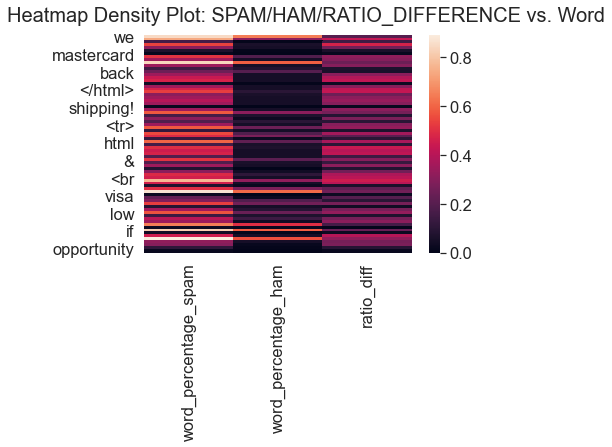

In [36]:
sns.heatmap(wrd_ratio_df)
plt.suptitle('Heatmap Density Plot: SPAM/HAM/RATIO_DIFFERENCE vs. Word', fontsize=20)

# Making a Precision-Recall Curve

Logistic regression calculates the probability that an example belongs to a certain class. To classify an example, an email will be called spam if the classifier gives it $>= 0.5$. This cutoff can be adjusted as necessary. 

A precision-recall curve shows the trade off for each possible cutoff probability. 

In [37]:
!pip install --user scikit-learn

In [38]:
from sklearn.metrics import precision_recall_curve
!pip install funcsigs

(0.0, 1.0)

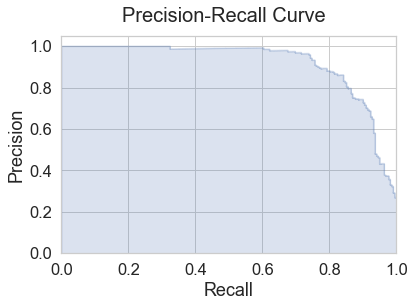

In [39]:
from funcsigs import signature

trainpro = model.predict_proba(val_Phi_train)[:,1]
precision, recall, _ = precision_recall_curve(Y_train, trainpro)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.suptitle('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# Kaggle Submission CSV

In [40]:
test_feature = words_in_texts(some_words_spam, test['email'])
test_predictions =model.predict(test_feature)

from datetime import datetime

# must be ndarray of predictions
assert isinstance(test_predictions, np.ndarray) 

# must be binary labels (0 or 1) and not probabilities
assert np.all((test_predictions == 0) | (test_predictions == 1))

# must be the right number of predictions
assert test_predictions.shape == (1000, )



In [43]:
# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]

submission_df

,Id,Class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
995,995,0
996,996,0
997,997,0
998,998,0


In [45]:
submission_df.to_csv("submission_{}.csv", index=False)

In [46]:
print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2020-08-08T12:09:33.csv.
You may now upload this CSV file to Kaggle for scoring.
